# 머신러닝 (Machine Learning)

## MLP(Multi-Layer Perceptron) - CIFAR10 데이터셋 분류 예제

### 1. 데이터 불러오기

In [1]:
# 사용 라이브러리 불러오기

## numpy: 파이썬에서 사용하는 대표적인 연산 라이브러리로 "행렬" 연산을 가능하게 해줍니다.
import numpy as np
## torch: 딥러닝을 모델을 구축하는데 있어서 핵심이 되는 라이브러리로, numpy와 같은 기능을 하지만, GPU를 이용한 "병렬계산"이 가능한 것이 특징이자 강점입니다.
import torch
## torchvision: 딥러닝에서 유명한 데이터셋(torchvison.datasets)과 모델(torchvision.models), 그리고 이미지 전처리 코드(torchvision.transforms)가 저장되어 있는 라이브러리입니다.
## 오늘은 저번 시간과 다르게 데이터셋을 불러온 후 전처리를 진행해야합니다. 따라서 전처리를 위해 transforms 또한 불러와 줍시다.
from torchvision import datasets, transforms

In [2]:
# Train dataset과 Test dataset을 각각 불러옵니다.
# 이때, 우리가 torch를 이용하여 데이터를 병렬처리해야하므로 단순 array로 이루어진 이미지를 Tensor라는 torch 자료형으로 바꾸어주어야합니다.
# 이를 가능하게 해주는 것이 위에서 말씀드린 torchvision.transforms입니다.

## Transformers.ToTensor(): 데이터를 Tensor로 변경해줌
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [01:25<00:00, 2000387.08it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


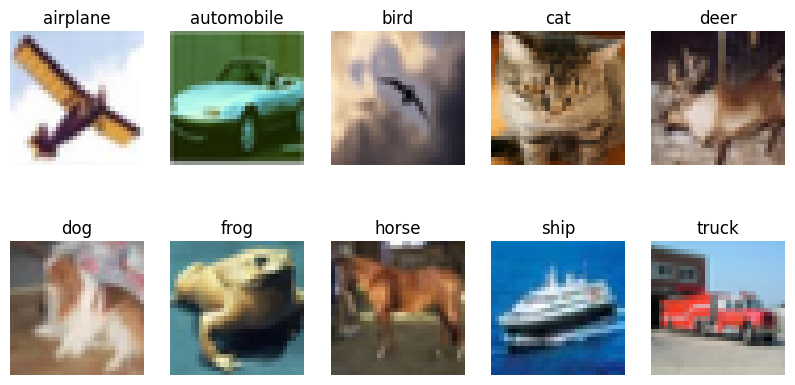

In [3]:
# 오늘도 시각화 툴을 이용하여 어떻게 생겼는지 확인해봅시다.
import matplotlib.pyplot as plt

labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
figure = plt.figure(figsize=(10, 5))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    while label != i-1:
        sample_idx = torch.randint(len(trainset), size=(1,)).item()
        img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

신기합니다. 오늘 설명드린대로 10개의 다양한 물체의 이미지로 이루어져 있군요. 이제 우리가 늘 했던 것처럼 train 데이터를 나눠봅시다.

### 2. 데이터 분할 (Train to Train/Validation)

In [4]:
# 오늘도 seed 고정은 잊지마세요! 내 결과를 재현하기 위해서는 필수입니다.
# 오늘은 numpy를 사용하지 않으므로 torch seed를 고정해주겠습니다.

## seed 고정
def seed_fix(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_fix(0)

In [5]:
# train 데이터의 이미지 개수 확인
train_size = len(trainset)
print(train_size)

50000


In [11]:
# 오늘은 데이터를 다르게 나누어보겠습니다.
# 우리가 현재 사용할 모델인 MLP는 학습을 반복적으로 진행하는데, 반복적인 학습을 위해선 반복적인 Shuffle이 필요합니다.
# 예를 들어, 모든 데이터에 대해서 모두 학습하고, 한번 섞고, 다시 모든 데이터에 대해서 학습하는 방식입니다.
# 이를 도와주는 것이 torch.utils.data에 있는 DataLoader라는 라이브러리입니다.
# 추가로 이 라이브러리에는 우리가 저번주에 했던, 데이터를 train과 validation으로 나누는 과정을 해주는 random_split 라이브러리도 있습니다.
# 위 두가지 라이브러리를 사용하여 학습을 위한 준비를 해봅시다.

## DataLoader, random_split 라이브러리 불러오기
from torch.utils.data import DataLoader, random_split

# 분할은 9:1로 진행합시다.
val_ratio = 0.1

## validation으로 사용할 데이터의 수 확인
split = int(train_size*val_ratio)

## 데이터 분할; random_split(데이터셋, [train 데이터의 수, validation 데이터의 수])
train_dataset, val_dataset = random_split(trainset, [train_size-split, split]) 

In [12]:
# 이제 우리는 데이터를 shuffle하며 불러오기위해 DataLoader를 사용해봅시다.
# DataLoader는 데이터를 불러올 때, batch라고 하는 단위로 불러오는데요, 예를 들어 data가 200개, batch가 64라면 학습하는 데이터의 양이 각각 64, 64, 64, 8이 됩니다.
# batch의 존재는 모델의 학습 속력이 더 빨라지게 도와줍니다.
# 공학적으로 컴퓨터는 0과 1 두가지의 신호를 보내기에 batch는 보통 2의 배수가 선호됩니다.
# 백문이 불여일견! 한번 만들어봅시다.

## train, validation, test dataloader로 변환
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=False)

In [15]:
# dataloader가 batch만큼 데이터를 가지고 있다는 것에 대해서 시각적으로 봅시다.
# 참고로 dataloader는 (data, label)의 형식을 가지고 있습니다.

## dataloader 안의 데이터를 모두 순회(확인)
for idx, (data, label) in enumerate(train_dataloader):
    ## 너무 많으니 개수를 제한
    if idx < 4 or idx > 700:
        print(f'{idx+1}번째 data의 개수 >> {len(data)}')
    if idx == 4:
        print('...')

1번째 data의 개수 >> 64
2번째 data의 개수 >> 64
3번째 data의 개수 >> 64
4번째 data의 개수 >> 64
...
702번째 data의 개수 >> 64
703번째 data의 개수 >> 64
704번째 data의 개수 >> 8


### 3. 모델 구조(아키텍쳐) 설계

In [16]:
# 자 이제 대망의 MLP를 작성해봅시다.
# 우리는 모델을 직접 작성할겁니다! 모델 코드를 처음 보는 분들이 많으실거라고 생각해요. 코드에서 이해가 안 가는 부분은 모두 질문주세요
# 일단 nn이라는 라이브러리를 불러와야합니다. nn은 모델을 설계할 때 도움을 주는 라이브러리라고 생각하시면 돼요.
# 자 이제 한번 만들어봅시다.

## nn 라이브러리 불러오기
import torch.nn as nn

In [17]:
# 모델 설계
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=3*32*32, hidden_dim=512, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = self.classifier(x)
        return x

이제 오늘 배웠던 그대로 Training 코드를 작성해봅시다. 이 과정을 통해 모델이 학습됩니다.

In [26]:
def train(model, dataloader, optim, criterion, device):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    
    for idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        pred = model(data)
        loss = criterion(pred, target)

        loss.backward()
        optim.step()
        optim.zero_grad()

        train_loss += loss.item()
        train_acc += (pred.argmax(1) == target).type(torch.float).sum().item()

    train_loss /= num_batches
    train_acc /= size

    print(f"Train: \n Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f}")

def evaluation(model, dataloader, device, test=False):
    model.eval()
    size = len(dataloader.dataset)
    validation_acc = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            pred = model(data)

            validation_acc += (pred.argmax(1) == target).type(torch.float).sum().item()

    validation_acc /= size

    print(f"{'Test' if test else 'Validation'}: \n Accuracy: {(100*validation_acc):>0.1f}%\n")

    return validation_acc

### 4. 모델 학습

#### 4-1. CUDA 연결

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### 4-2. 학습 진행

In [24]:
## 모델 저장을 위한 라이브러리
import copy

# 우리가 만든 모델을 불러옵시다.
model = NeuralNetwork().to(device)

# 또, 결과가 가장 좋았던 모델을 저장하기위해 가장 좋은 결과를 저장하는 변수와 모델을 저장하는 변수를 하나씩 만듭시다.
best_model = None
best_val_acc = 0

# loss를 계산하는 방식은 CrossEntropyLoss를 사용합시다.
criterion = nn.CrossEntropyLoss()

# 또한, 가중치를 업데이트하는 방식은 Adam을 사용합시다.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 가볍게 10번 정도 학습해봅시다. epoch는 반복횟수를 의미하는 단어입니다.
epochs = 10
for epoch in range(epochs):
    print(f'Epoch {epoch+1} >>>')
    train(model, train_dataloader, optimizer, criterion, device)
    val_acc = evaluation(model, val_dataloader, device)
    if val_acc > best_val_acc:
        best_model = copy.deepcopy(model)

Epoch 1 >>>
Train: 
 Accuracy: 32.0%, Avg loss: 1.861754 

Validation: 
 Accuracy: 37.3%

Epoch 2 >>>
Train: 
 Accuracy: 39.6%, Avg loss: 1.682837 

Validation: 
 Accuracy: 40.4%

Epoch 3 >>>
Train: 
 Accuracy: 42.8%, Avg loss: 1.592519 

Validation: 
 Accuracy: 43.3%

Epoch 4 >>>
Train: 
 Accuracy: 45.4%, Avg loss: 1.523203 

Validation: 
 Accuracy: 44.5%

Epoch 5 >>>
Train: 
 Accuracy: 46.7%, Avg loss: 1.482433 

Validation: 
 Accuracy: 44.9%

Epoch 6 >>>
Train: 
 Accuracy: 48.2%, Avg loss: 1.448108 

Validation: 
 Accuracy: 46.6%

Epoch 7 >>>
Train: 
 Accuracy: 49.3%, Avg loss: 1.412875 

Validation: 
 Accuracy: 46.1%

Epoch 8 >>>
Train: 
 Accuracy: 50.6%, Avg loss: 1.386107 

Validation: 
 Accuracy: 47.4%

Epoch 9 >>>
Train: 
 Accuracy: 51.2%, Avg loss: 1.362871 

Validation: 
 Accuracy: 48.6%

Epoch 10 >>>
Train: 
 Accuracy: 52.2%, Avg loss: 1.334466 

Validation: 
 Accuracy: 48.4%



In [27]:
# 성능이 점점 올라가는게 보는 재미가 있지 않나요?
# 이젠 저장된 모델을 이용하여 test 결과가 얼마나 나오는지 확인해봅시다!

test_acc = evaluation(best_model, test_dataloader, device, test=True)

Test: 
 Accuracy: 50.6%



축하합니다! 여러분은 이제 요즘 핫한 분야인 딥러닝에 처음 발을 들여놓게 되었습니다!<br><br>
모델을 설계하고 training 코드를 이해하고, 또 결과를 낼 수 있다면 여러분은 조금 더 나아가 자신의 분야에 적용까지 할 수 있을 것이라고 생각합니다.<br><br>
세상에 나와있는 모든 모델의 골자는 이렇고, 특히 training은 위 형태를 거의 따라갑니다.<br><br>
오늘 정말 고생 많으셨고, 앞으로는 모델의 성능을 어떻게 분석해보면 좋을지에 대해서 한번 배워봅시다! 감사합니다 :)